### Импортируем необходимые библиотеки для работы с базой данных и прогнозирования временных рядов.

In [1]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний

In [2]:
#общие штуки для кручения данных
import pandas as pd
import pandahouse as ph
import numpy as np

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #это полезно для визуализации MCMC

#эксплораторные штуки
from orbit.eda import eda_plot

Для начала нам необходимо определиться с ключевой метрикой, которую мы будем пытаться спрогнозировать!

Метрик, которые показывают эффективность пользователей несколько, это и число активных пользователей, и количество взаимодействий пользователей с контентом (количество постов, лайков, просмотров), и среднее время сессии и ещё , вероятно, какие то!

Я в качестве ключевой возьму самую верхнеуровневую, как мне кажется, метрику количества активных пользователей на единицу времени! Мы знаем такие метрики как `DAU`, `WAU`, `MAU`! Но я хочу использовать временной интервал в 1 час и назову свою ключевую метрику `HAU` - Hourly activ users! В качестве регрессора потенциально буду рассматривать количество постов в час, т к предполагаю, что эти 2 метрики должны неплохо коррелировать и , возможно, добавление регрессора в модель может ощутимо повлиять на её эффективность!

Почему именно часовой интервал? Потому что нас интересуют пиковые значения активности в приложении, т к именно они будут нагружать максимально сильно наши сервера и потенциально приводить к своям в работе приложения! И совершенно очевидно, что у этой активности пользователей есть внутридневная сезонность, т е есть пиковые (условно вечерние) часы, когда пользователи будут максимально активны, а есть ночные часы, когда активность, предположительно, может сильно снижаться!

Нас в данном случаем будет интересовать верхняя граница доверительного интервала спрогнозированной метрики, потому как мы хотим прогноз не в целом по изменчивости активности, а нас интересует активность пользователей в контексте потенциальных сбоев в работе приложения, т е грубо говоря мы хотим "очертить" верхнюю границу активности!

In [4]:
#коннект к базе данных

connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250220',
'user':'student',
'password':'dpo_python_2020'
}

Далее я буду использовать запрос, для получения почасового количества активных пользователей, но немного отфильтрую даты (уберу из обучающей выборки данные первой недели работы нашего приложения)! Почему я считаю что это можно сделать? Потому что , во-первых, в первую неделю мы только запустили наше приложение, налили первый трафик, только только начинаем набирать обороты и , я считаю, что эти данные не так важны для обучения нашей модели, во-вторых, что важно, это количество имеющихся у нас данных и горизонт прогнозирования, который нас интересует (1 месяц)! Мы бы не убирали эти данные начальные ни в коем случае, если бы могли и хотели учесть более глобальные тренды в данных или более глобальную сезонность, до которой у нас просто нет доступа (или нет нужного количества данных, к примеру несколько лет данных)!

В итоге у нас есть 2 с лишним месяца данных с постепенным положительным затухающим трендом, по этому убрать неделю первых данных считаю возможным!

In [15]:
#подгрузим данные о часовой активности пользователей, отфильтровав 1-ю неделю данных

query = '''
SELECT 
    toStartOfHour(time) hour_time,
    count(DISTINCT user_id) AS HAU
FROM 
    {db}.feed_actions
WHERE 
    toDate(time) BETWEEN '2025-01-10' AND '2025-03-14'
GROUP BY 
    hour_time
ORDER BY 
    hour_time
'''

In [12]:
activity = ph.read_clickhouse(query=query, connection=connection)
activity.head()

,hour_time,HAU
0,2025-01-10 00:00:00,357
1,2025-01-10 01:00:00,307
2,2025-01-10 02:00:00,229
3,2025-01-10 03:00:00,163
4,2025-01-10 04:00:00,177


In [13]:
#зададим рисовательный шаблон для сиборна
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

<Axes: xlabel='hour_time', ylabel='HAU'>

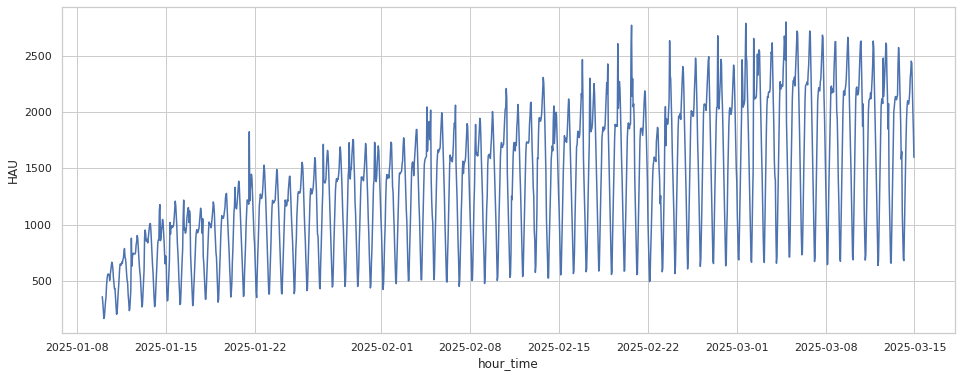

In [16]:
#посмотрим на наши данные, увидим сезонность внутридневную и плавный положительный затухающий тренд
sns.lineplot(data=activity, x='hour_time', y='HAU')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

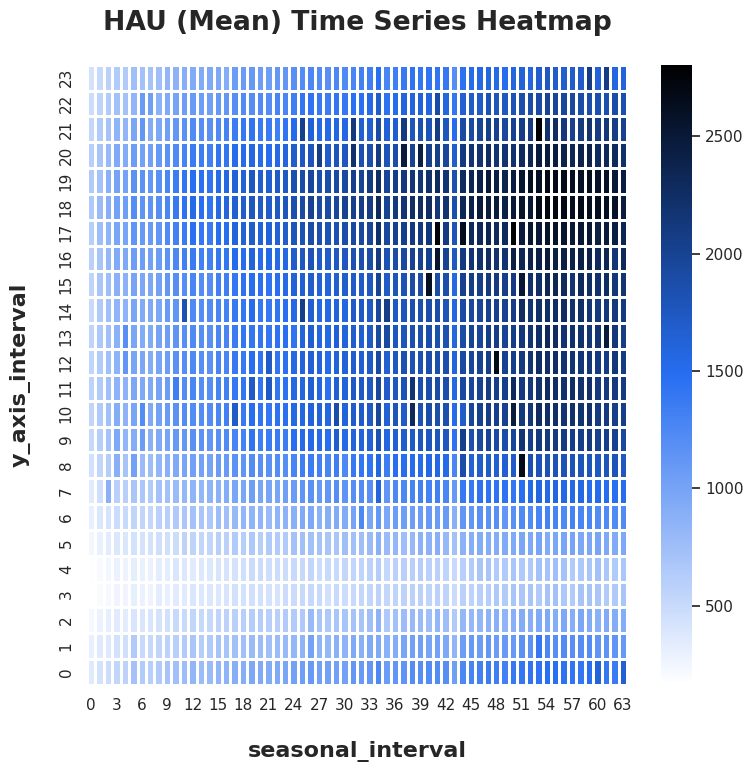

In [18]:
#глянем на тепловуя карту и также задетектируем некоторую внутридневную сезонность активности пользователей
_ = eda_plot.ts_heatmap(df=activity, date_col="hour_time", value_col="HAU", seasonal_interval=24, normalization=False)

### Далее составим некоторый алгоритм действий по прогнозированию нашей целевой метрики `HAU`:

* Сначала подумаем о количестве имеющихся данных, горизонте прогнозирования и решим сможем ли мы валидировать такую модель и если нет, то с каким горизонтом прогнозирования с учётом нашего количества данных, мы сможем работать;

* Затем обучим некоторое количество разных моделей и взглянем визуально как они предсказывают тестовые данные;

* Посмотрим на информационные критерии оценки моделей для первичного сравнения;

* Определимся с разновидностью формирования подвыборок для бэктестинга и проведем таки тесты моделей для окончательного решения по выбору оптимальной модели.




### Возможно ли предсказать активность пользователей на целый месяц вперёд имея данных на 2 с лишним месяца?

Короткий ответ - да, можно! Мы действительно можем обучить модель, которая будет выдавать нам прогноз на месяц. Вопрос в качестве такого предсказания или иными словами, сможем ли мы валидировать такую модель? Очевидный ответ - нет! У нас просто напросто недостаточно данных для бэктестов, нет возможности на наших данных создать подвыборки таких же размеров, что у нас есть с учётом того что мы имеем дело с временными рядами и нам нужно сохранять временную зависимость в данных!

Тогда другой вопрос - а какой горизонт прогнозирования мы можем использовать, чтобы иметь возможность провалидировать модель?
Чем меньше у нас будет сэмплов для бэктестинга или чем больше будет отношение размера тестовой выборки к тренировочной, тем большей степени наш прогноз будет превращаться в "гадание на кофейной гуще"! По этому, перебрав некоторое количество вариантов, а также использую некоторый стандарт отношения тренировочной выборки к тестовой  как 70-80 % на 30-20 % соответственно, я считаю что мы можем выбрать горизонт прогнозирования в одну неделю, а размер минимальной выборкй для обучения при бектестах будет равным 1 месяцу!

### Теперь займёмся обучением моделей и предсказанием нашей целевой метрики!

**Damped Local Trend (DLT)** - наиболее отлаженная модель в Orbit, учитывающая некоторый коэффициент затухания тренда и не использующая никаких регрессоров.

In [21]:
no_reg_model = DLT(response_col="HAU", #название колонки с метрикой
          date_col="hour_time", #название колонки с датами-временем
          seasonality=24, #длина периода сезонности
          estimator="stan-map", #алгоритм оценки
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

2025-03-15 15:17:43 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [29]:
#обучаем модель
no_reg_model.fit(activity)

In [24]:
future_df = no_reg_model.make_future_df(periods=24*7) # 7 дней по 24 часа
future_df.head()

,hour_time
0,2025-03-15 00:00:00
1,2025-03-15 01:00:00
2,2025-03-15 02:00:00
3,2025-03-15 03:00:00
4,2025-03-15 04:00:00


In [25]:
predicted_df = no_reg_model.predict(df=future_df)
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95
0,2025-03-15 00:00:00,1324.691123,1448.018570,1575.828823
1,2025-03-15 01:00:00,926.104953,1046.156409,1174.918655
2,2025-03-15 02:00:00,699.435038,832.198948,959.672721
3,2025-03-15 03:00:00,470.393869,588.323487,710.232483
4,2025-03-15 04:00:00,462.099736,585.062027,707.286246


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

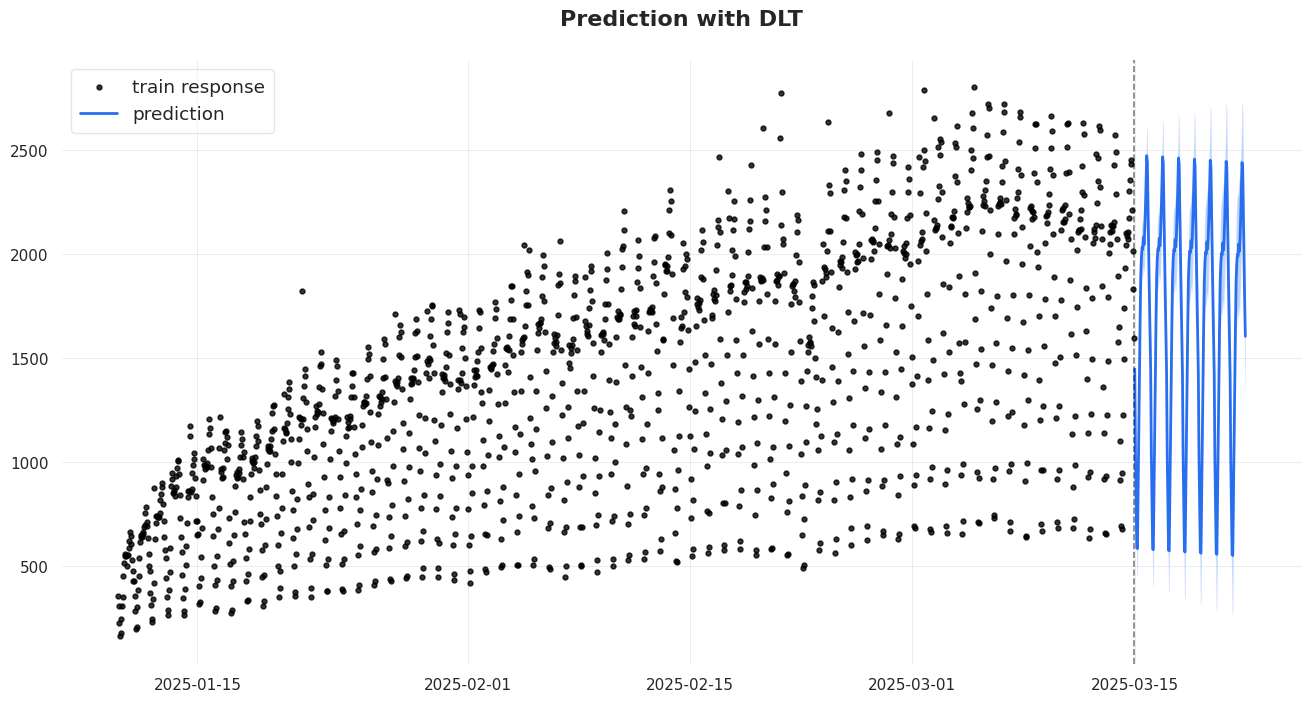

In [32]:
#визуализируем
_ = plot_predicted_data(activity, predicted_df, "hour_time", 'HAU', title='Prediction with DLT')

In [30]:
#декомпозируем предсказание, тренд и сезонность
predicted_df = dlt.predict(df=future_df, 
                           decompose=True) #говорит, что нам нужна декомпозиция предсказания
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-03-15 00:00:00,1317.469044,1448.018570,1570.127005,1372.038344,1502.587870,1624.696305,-54.5693,-54.5693,-54.5693,0.0,0.0,0.0
1,2025-03-15 01:00:00,927.218814,1046.156409,1162.730481,1383.420814,1502.358409,1618.932481,-456.2020,-456.2020,-456.2020,0.0,0.0,0.0
2,2025-03-15 02:00:00,705.187542,832.198948,942.813084,1375.117542,1502.128948,1612.743084,-669.9300,-669.9300,-669.9300,0.0,0.0,0.0
3,2025-03-15 03:00:00,463.110854,588.323487,715.055097,1376.686854,1501.899487,1628.631097,-913.5760,-913.5760,-913.5760,0.0,0.0,0.0
4,2025-03-15 04:00:00,445.964435,585.062027,702.261896,1362.572435,1501.670027,1618.869896,-916.6080,-916.6080,-916.6080,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

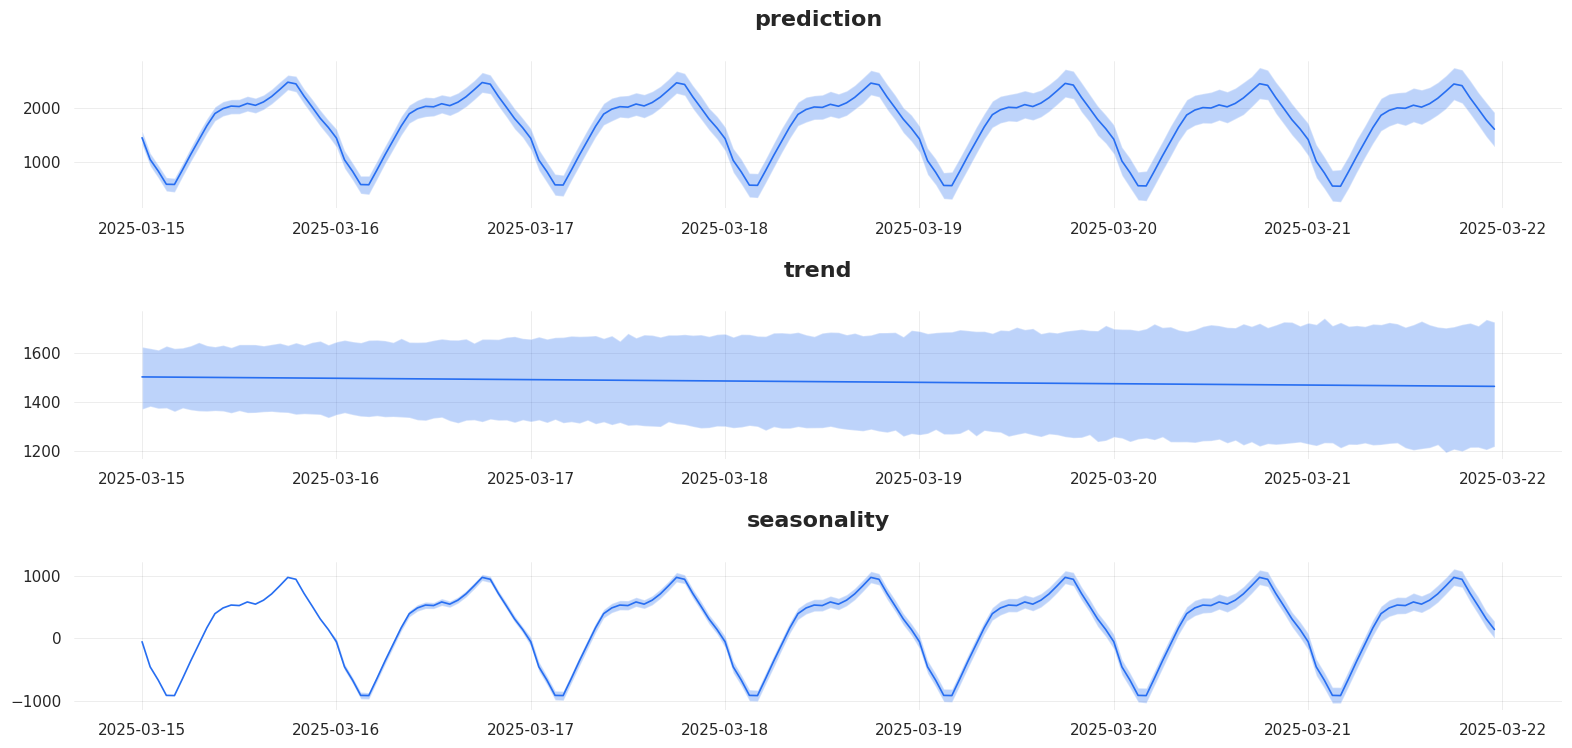

In [31]:
#визуализируем
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

**Метод Markov Chain Monte Carlo (MCMC)** - ровная противоположность MAP! Он оценивает доверительные интервалы для всего, и имеет гораздо больше теоретических гарантий точности - но при этом не самый шустрый. Попробуем оценить модель с помощью него:

In [33]:
dlt_mcmc = DLT(seasonality=24, response_col="HAU", date_col="hour_time", 
               estimator='stan-mcmc', #новый алгоритм оценки
               num_warmup=2000, #время "разогрева"
               num_sample=1000) #время сэмплирования

In [34]:
#обучаем
dlt_mcmc.fit(activity)

2025-03-15 15:25:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

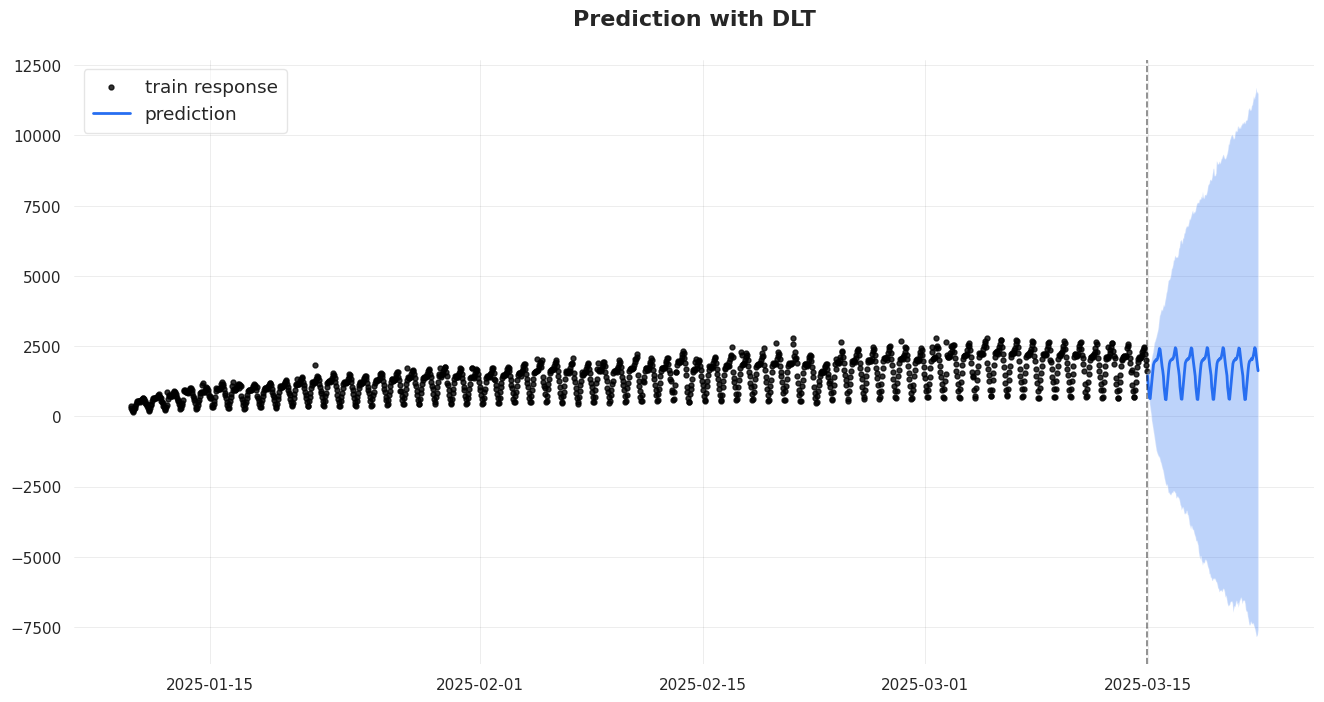

In [36]:
#визуализируем и посмотрим на огроменный доверительный интервал нашего предсказания
future_df = dlt_mcmc.make_future_df(periods=24*7)

predicted_df = dlt_mcmc.predict(df=future_df)

_ = plot_predicted_data(activity, predicted_df, "hour_time", 'HAU', title='Prediction with DLT')

In [37]:
predicted_df = dlt_mcmc.predict(df=future_df, decompose=True)

predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-03-15 00:00:00,1275.003468,1441.856342,1605.251628,1282.521753,1475.839701,1662.080337,-122.75240,-3.195110,0.789479,0.0,0.0,0.0
1,2025-03-15 01:00:00,910.637698,1104.500026,1580.190899,1018.022603,1446.860991,1675.027032,-525.12890,-176.889000,-0.037551,0.0,0.0,0.0
2,2025-03-15 02:00:00,672.847003,896.569014,1614.747789,797.081296,1444.052357,1686.547254,-737.69730,-281.830850,0.254498,0.0,0.0,0.0
3,2025-03-15 03:00:00,436.052103,660.749348,1708.410320,569.849071,1449.473918,1741.210394,-981.79185,-402.558000,-0.385408,0.0,0.0,0.0
4,2025-03-15 04:00:00,266.052195,638.860584,1851.949809,264.703001,1453.671179,1847.433730,-985.19600,-399.488735,17.896495,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

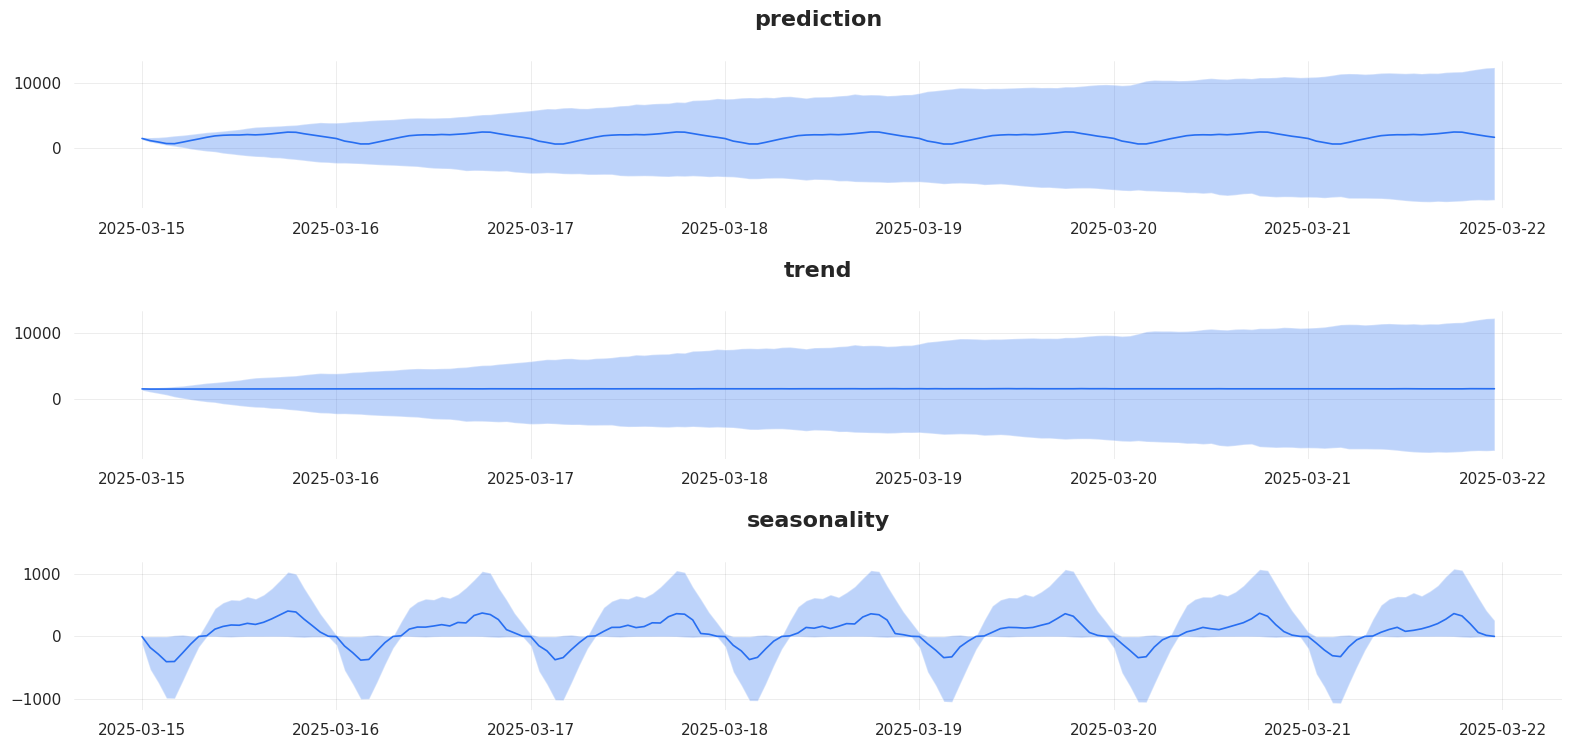

In [38]:
#декомпозируем и увидим так огромные доверительные интервалы
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

Проверим отдельно настройку метода **MCMC**.

In [519]:
params = dlt_mcmc.get_posterior_samples(permute=False) #достаём информацию о параметрах

params.keys() #их названия - можно залезть в оригинальный код на Stan, чтобы вычислить их значение

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'loglk'])

In [520]:
params["obs_sigma"].shape #лучше смотреть те, у которых третьего измерения либо нет, либо оно равно 1

(4, 250)

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

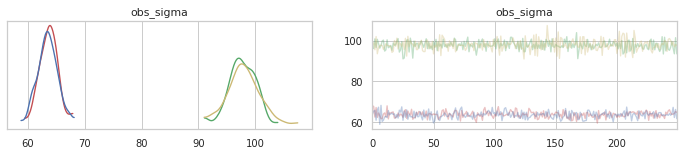

In [521]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")

Марковские цепи не сходятся к примерно одному диапазону значений, а это означает, что мы не можем в данном виде провалидировать модель **MCMC**!

**Далее попробуем добавить в нашу модель регрессор - количество постов в час (`posts`)!**

In [39]:
#подгрузим необходимые данные
query = '''
SELECT 
    toStartOfHour(time) hour_time,
    count(post_id) posts
FROM 
   {db}.feed_actions
WHERE 
    toDate(time) BETWEEN '2025-01-10' AND '2025-03-14'
GROUP BY hour_time
ORDER BY 
    hour_time
'''

In [40]:
posts = ph.read_clickhouse(query=query, connection=connection)
posts.head()

,hour_time,posts
0,2025-01-10 00:00:00,8230
1,2025-01-10 01:00:00,6774
2,2025-01-10 02:00:00,5061
3,2025-01-10 03:00:00,3459
4,2025-01-10 04:00:00,3529


<Axes: xlabel='hour_time', ylabel='posts'>

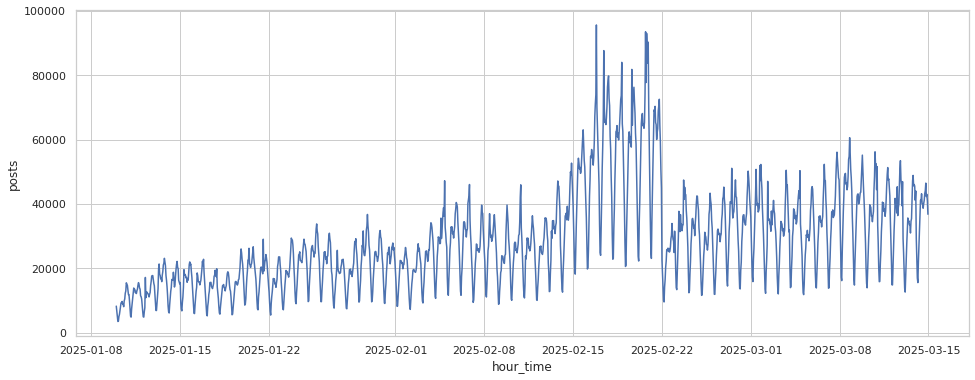

In [41]:
#как меняется число постов
sns.lineplot(x="hour_time", y="posts", data=posts)

In [42]:
#объеденим данные с целевой метрикой и регрессором в один датафрейм
data_reg = activity.merge(posts)
data_reg.head()

,hour_time,HAU,posts
0,2025-01-10 00:00:00,357,8230
1,2025-01-10 01:00:00,307,6774
2,2025-01-10 02:00:00,229,5061
3,2025-01-10 03:00:00,163,3459
4,2025-01-10 04:00:00,177,3529


In [43]:
data_reg['posts'] = data_reg['posts'].astype('int64')

In [45]:
#прсмотрим кореляцию и увидим , что она однозначно есть
data_reg.drop("hour_time", axis=1).corr() 

,HAU,posts
HAU,1.000000,0.783346
posts,0.783346,1.000000


При построении модели с регрессором важно понимать , что мы должны знать (или предсказать) значения регрессора на интервал горизонта прогнозирования целевой метрики, иначе данный способ работать не будет! 

По этому разобъём наши данные на тренировочную выборку и тестовую, в которой мы знаем значения регрессора и посмотрим как наша модель предсказывает значения , которые по факту у нас уже есть!

In [46]:
train_dat = data_reg.query("hour_time < '2025-03-07 00:00:00'") #возьмём часть данных для обучения
test_dat = data_reg.query("hour_time >= '2025-03-07 00:00:00'").astype({"posts":"int64"}) #а это будем предсказывать - важно сконвертировать в инт

In [47]:
reg_model = DLT(response_col="HAU",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000,
                regressor_col=["posts"] #наша колонка с регрессором! Должна быть списком
               ) 

reg_model.fit(train_dat)

2025-03-15 15:49:45 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

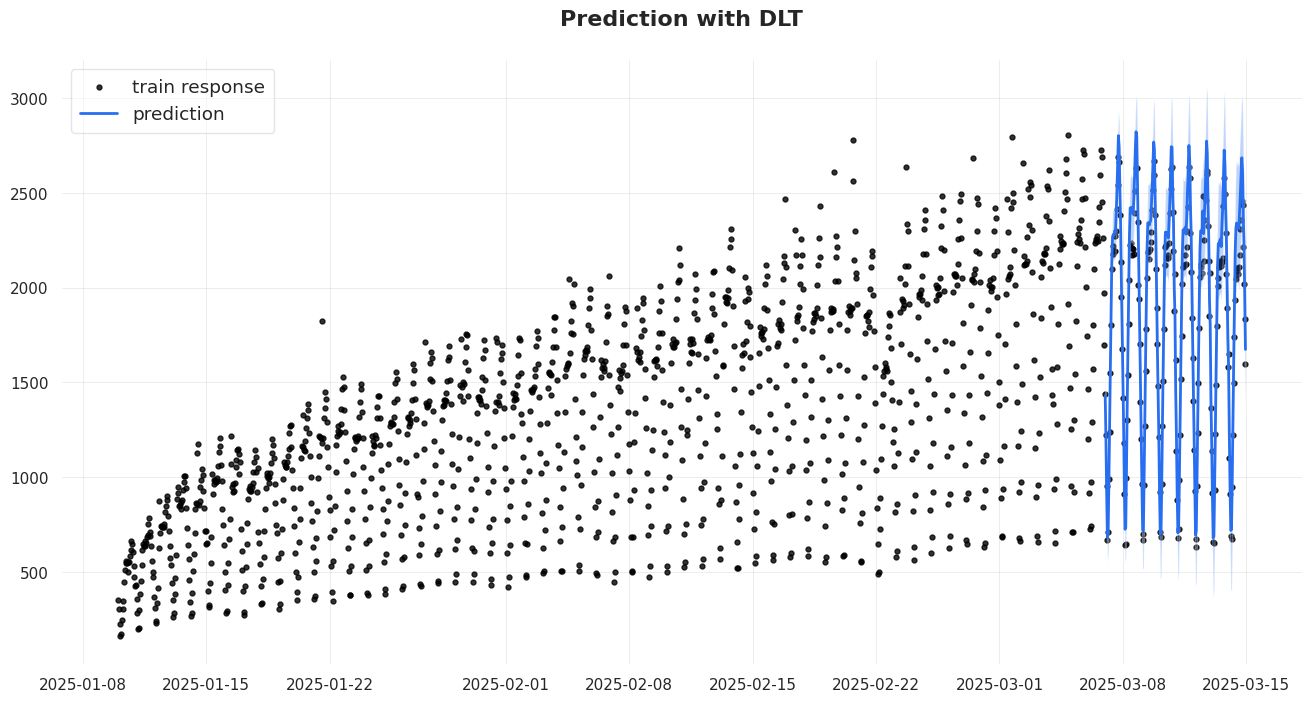

In [49]:
#визуализируем предсказание и увидим , что модель неплохо предсказывает истинные значения, особенно верхние пиковые значения, которые нас больше всего интересуют
predicted_df_reg = reg_model.predict(df=test_dat)

_ = plot_predicted_data(data_reg, predicted_df_reg, "hour_time", 'HAU', title='Prediction with DLT') 

In [50]:
predicted_df = reg_model.predict(df=test_dat, decompose=True)

predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-03-07 00:00:00,1309.740902,1429.982131,1548.785208,1187.530844,1307.772073,1426.575150,-267.971,-267.971,-267.971,390.181058,390.181058,390.181058
1,2025-03-07 01:00:00,1086.439122,1206.958256,1320.965904,1187.234660,1307.753794,1421.761442,-438.395,-438.395,-438.395,337.599462,337.599462,337.599462
2,2025-03-07 02:00:00,796.059165,918.808057,1034.589988,1184.986624,1307.735515,1423.517447,-640.724,-640.724,-640.724,251.796541,251.796541,251.796541
3,2025-03-07 03:00:00,561.180635,684.289155,799.177865,1184.608716,1307.717236,1422.605946,-796.641,-796.641,-796.641,173.212919,173.212919,173.212919
4,2025-03-07 04:00:00,590.354486,710.053280,836.593486,1188.000164,1307.698958,1434.239164,-772.880,-772.880,-772.880,175.234322,175.234322,175.234322


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

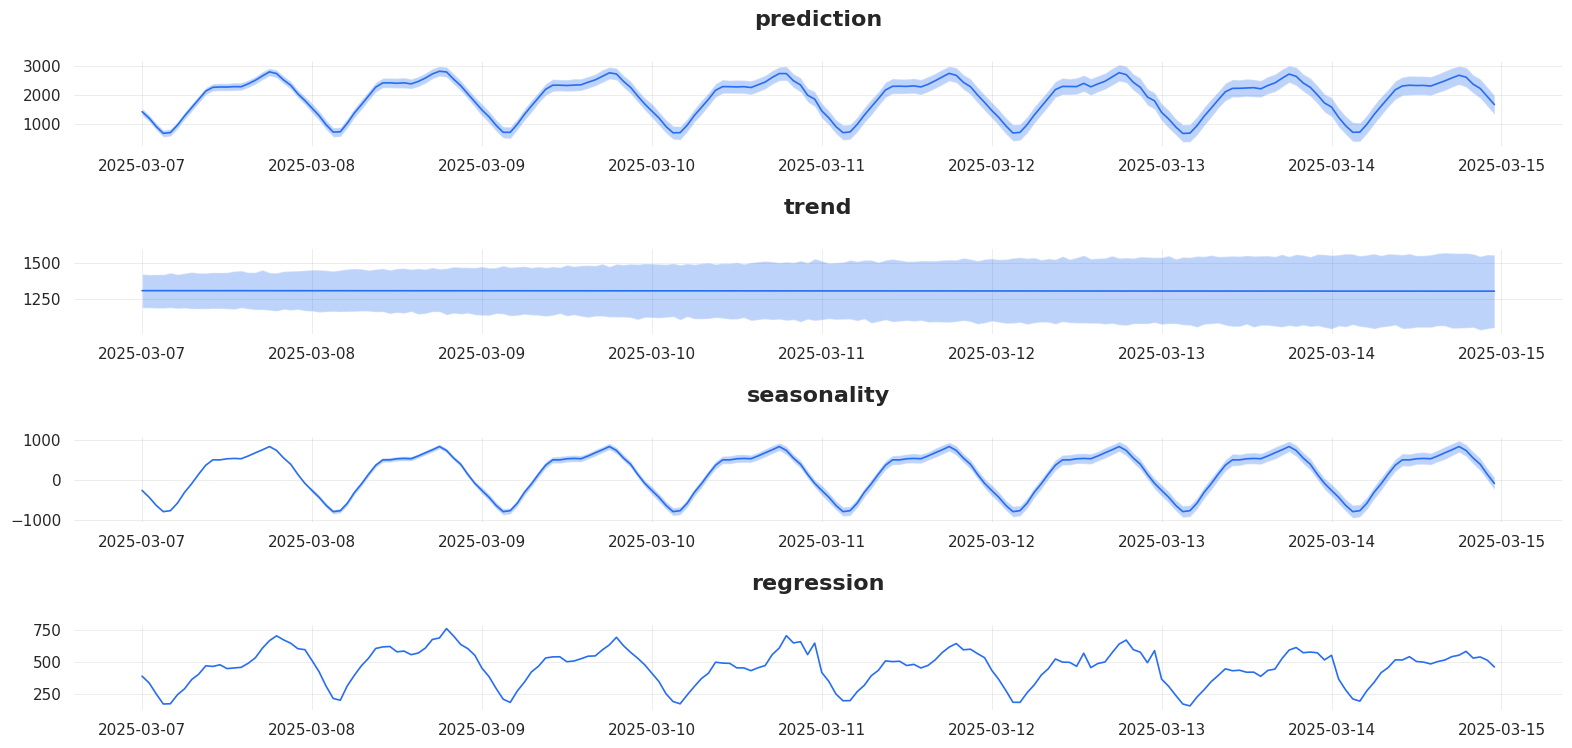

In [51]:
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality', "regression"])

In [53]:
#посмотрим на коэффициент регрессии
reg_model.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,posts,Regular,0.012555


## Теперь метод априорного распределения

Если у нас есть какие-то предварительные убеждения о том, в какую сторону должен быть направлен регрессор, какое его наиболее вероятное значение, насколько мы в этом значении уверены - это можно включить в модель как дополнительный источник информации!

In [55]:
reg_model_prior = DLT(response_col="HAU",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["posts"], 
                regressor_sign=["+"], #допустим, мы считаем, что связь обязательно положительная
                regressor_beta_prior=[0], #пусть мы думаем, что истинное значение коэффициента - вот такое
                regressor_sigma_prior=[0.2] #и зададим уровень уверенности
               ) 

2025-03-15 15:55:28 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [56]:
reg_model_prior.fit(train_dat)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

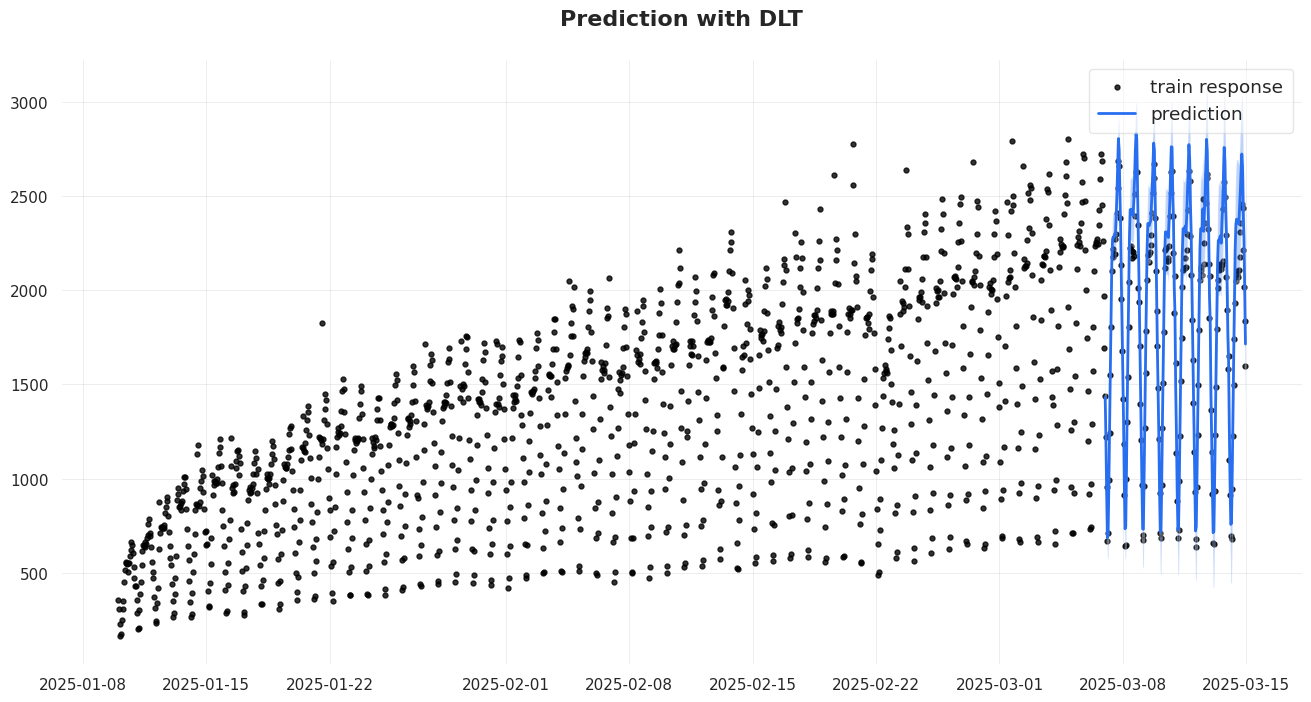

In [60]:
#посмотрим на результат и увидим очень похожие предсказания
predicted_df_prior = reg_model_prior.predict(df=test_dat)

_ = plot_predicted_data(data_reg, predicted_df_prior, "hour_time", 'HAU', title='Prediction with DLT') 

In [61]:
#и коэффициент регрессии тоже практически такой же
reg_model_prior.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,posts,Positive,0.012527


## Регуляризация

Теперь прибегнем к технике **регуляризации** - дополнительных штрафов к коэффициентам модели, чтобы они не становились слишком большими, особенно если регрессор плохой. 

По умолчанию оно стоит как `fixed_ridge`. Зададим `auto_ridge` - эта опция адаптивно подбирает оптимальную степень регуляризации на основе данных.

In [62]:
reg_model_auto = DLT(response_col="HAU",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["posts"], 
                regression_penalty="auto_ridge" #наш новый параметр
               ) 

reg_model_auto.fit(train_dat)

2025-03-15 16:08:50 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

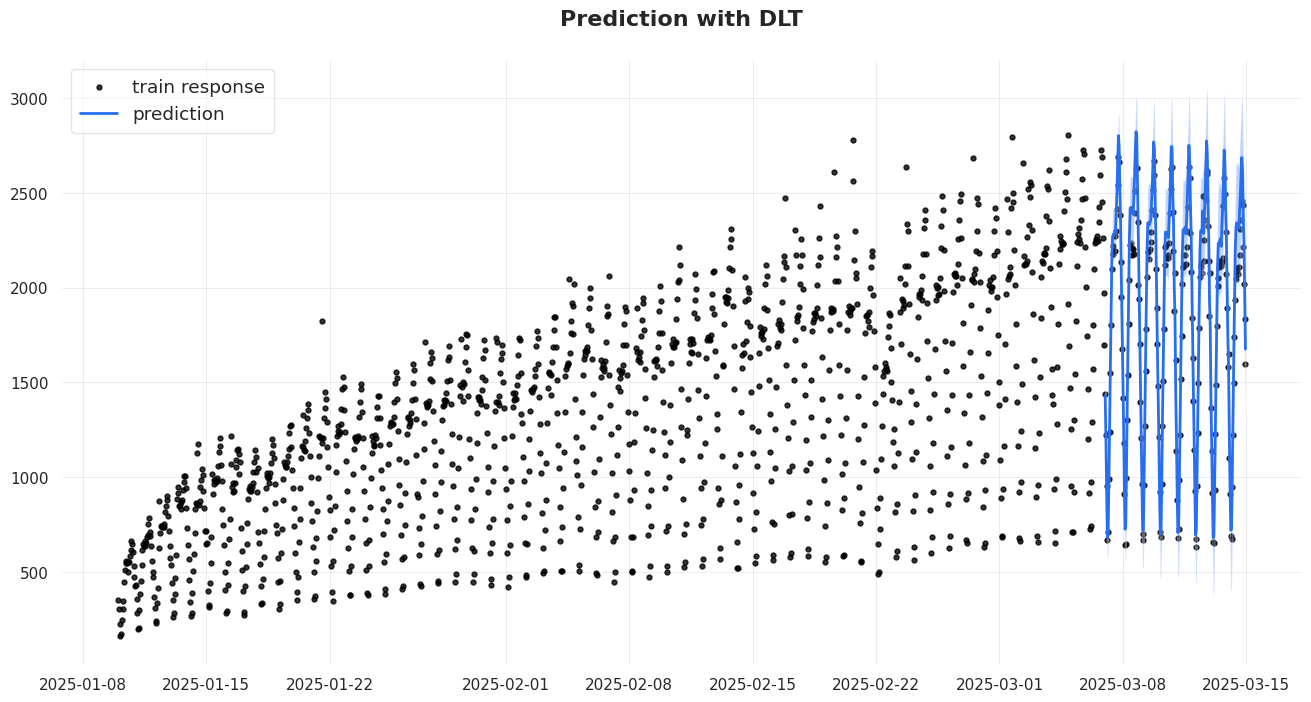

In [65]:
#видим также очень похожий прогноз
predicted_df_auto = reg_model_auto.predict(df=test_dat)

_ = plot_predicted_data(data_reg, predicted_df_auto, "hour_time", 'HAU', title='Prediction with DLT')

In [66]:
#и коэффициент регрессии
reg_model_auto.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,posts,Regular,0.012515


Применим  `lasso` - оно обычно "зануляет" плохие регрессоры.

In [67]:
reg_model_lasso = DLT(response_col="HAU",
                date_col="hour_time", 
                seasonality=24,
                estimator="stan-map", 
                n_bootstrap_draws=1000, 
                regressor_col=["posts"], 
                regression_penalty="lasso"
               ) 

reg_model_lasso.fit(train_dat)

2025-03-15 16:11:49 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

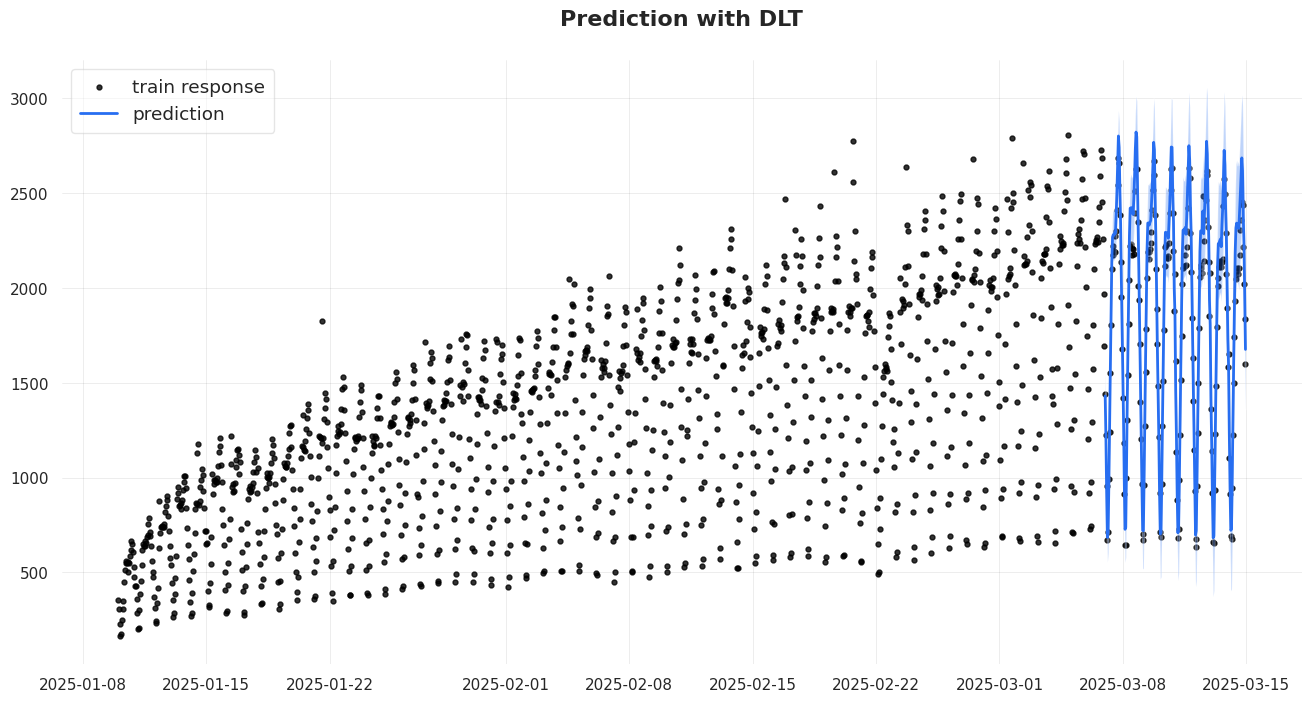

In [69]:
#кажется такой способ также показывает похожий результат
predicted_df_lasso = reg_model_lasso.predict(df=test_dat)

_ = plot_predicted_data(data_reg, predicted_df_lasso, "hour_time", 'HAU', title='Prediction with DLT') #кажется, стало хуже

In [71]:
#как и коэффициент регрессии
reg_model_lasso.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,posts,Regular,0.012564


## Информационные критерии

Посмотрим на показания информационных критериев `BIC` и `RMSSE` для первичного сравнения наших моделей!

In [72]:
print(f"Без регрессора: {no_reg_model.get_bic()}")
print(f"С регрессором: {reg_model.get_bic()}")
print(f"С информативным распределением: {reg_model_prior.get_bic()}")
print(f"С auto-ridge: {reg_model_auto.get_bic()}")
print(f"С lasso: {reg_model_lasso.get_bic()}")

Без регрессора: 17989.115787920255
С регрессором: 15453.563395554802
С информативным распределением: 15450.404095554803
С auto-ridge: 15453.479615554801
С lasso: 15453.472895554802


Кажется, модель с информативным распределением, как и все модели с регрессором показывают себя лучше!

Посмотрим какой будет результат по метрике `RMSSE`!

In [74]:
from orbit.diagnostics.metrics import rmsse

In [75]:
print(f"Без регрессора: {rmsse(test_dat.HAU.values, predicted_df.prediction.values, train_dat.HAU.values)}")
print(f"С регрессором: {rmsse(test_dat.HAU.values, predicted_df_reg.prediction.values, train_dat.HAU.values)}")
print(f"С информативным распределением: {rmsse(test_dat.HAU.values, predicted_df_prior.prediction.values, train_dat.HAU.values)}")
print(f"С auto-ridge: {rmsse(test_dat.HAU.values, predicted_df_auto.prediction.values, train_dat.HAU.values)}")
print(f"С lasso: {rmsse(test_dat.HAU.values, predicted_df_lasso.prediction.values, train_dat.HAU.values)}")

Без регрессора: 0.6328430297395173
С регрессором: 0.6328430297395173
С информативным распределением: 0.7174306778086665
С auto-ridge: 0.6350628943598652
С lasso: 0.6361242947015148


А вот по метрике `RMSSE` модели с регрессором и без регрессора показывают примерно одинаковые результаты!

### Далее перейдём к бэктестам!

Сначала определимся с типом окна данных в бектестах и я возьму вариант `expanding`, т к альтернативный способ `rolling` используется когда у нас данные волатильны и основная информация о предсказании находится в ближайшем прошлом! У нас же данные не такие волатильные , а изменяются примерно в диапазоне определенном, так называемом "боковике" или "flat"!

In [76]:
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга 
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров

In [87]:
#модель без регрессора

bt_exp = BackTester(
    model=no_reg_model, #наша моделька
    df=activity, #датафрейм для обучения
    min_train_len=24*31, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*7, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

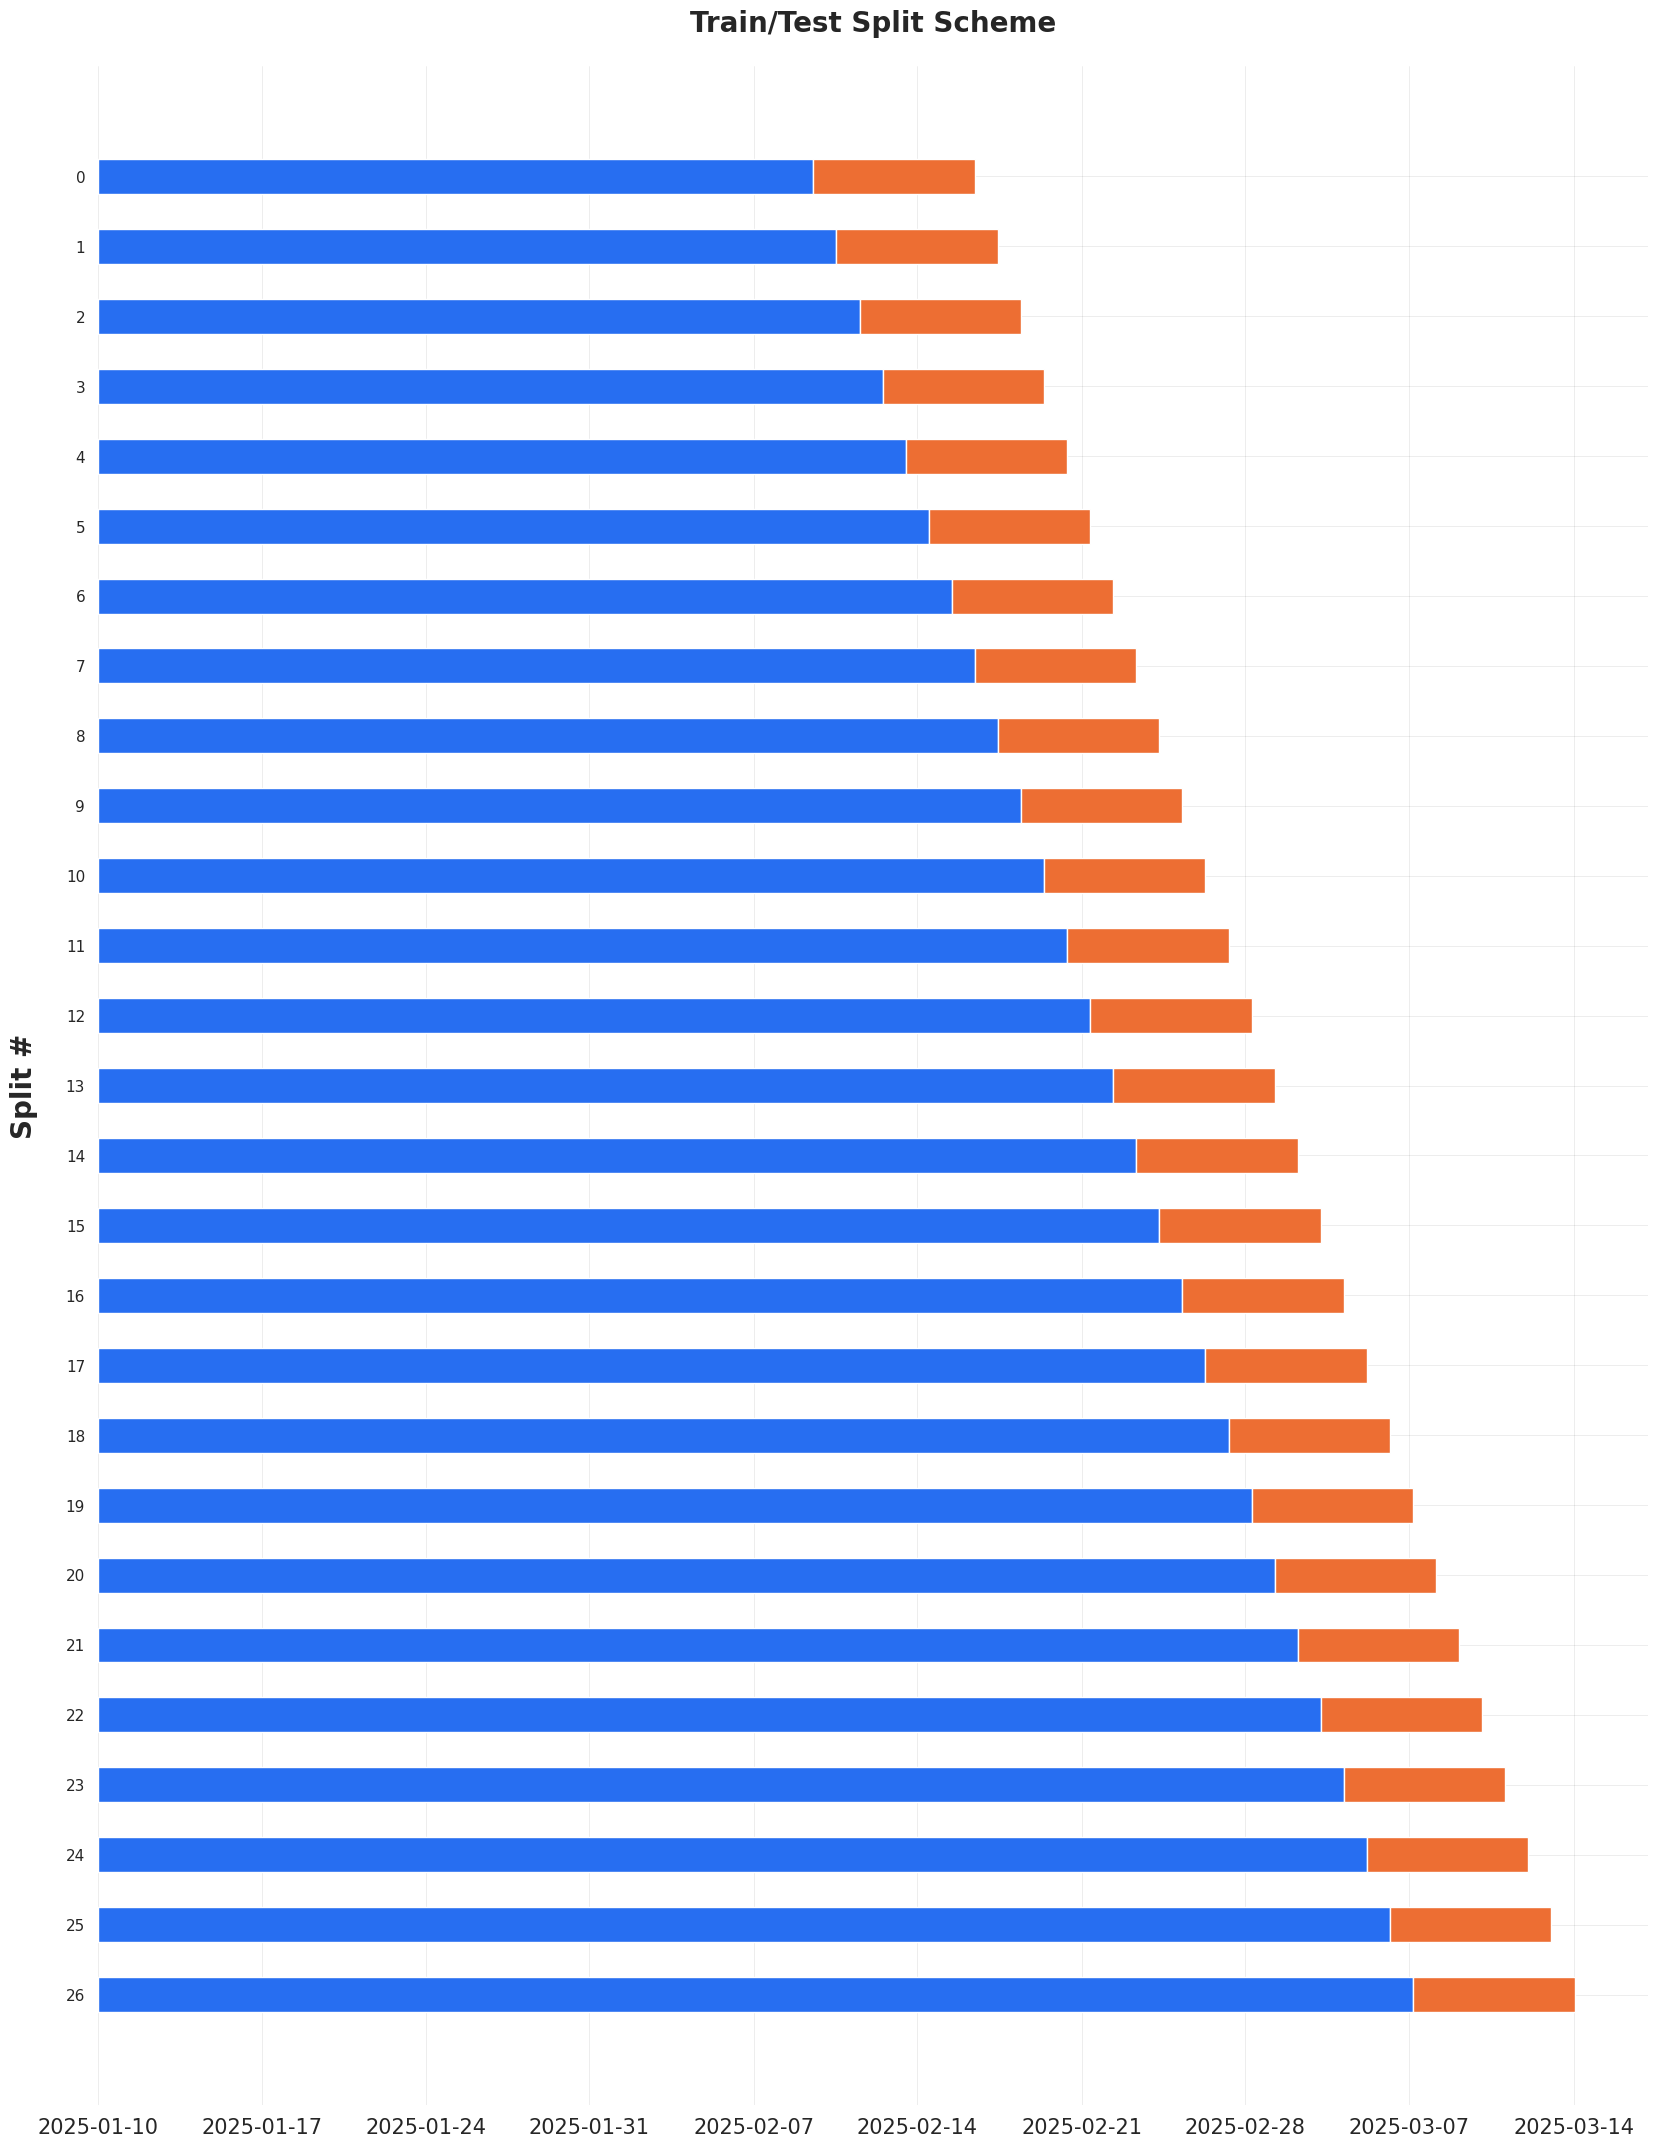

In [80]:
bt_exp.plot_scheme()

In [81]:
bt_exp.fit_predict() #обучаем
bt_exp.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,0.085912,False
1,wmape,0.077513,False
2,mape,0.085468,False
3,mse,35430.567732,False
4,mae,130.875854,False
5,rmsse,0.876617,False


In [88]:
#модель с регрессором

bt_exp_reg = BackTester(
    model=reg_model, #наша моделька
    df=data_reg, #датафрейм для обучения
    min_train_len=24*31, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*7, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

In [86]:
bt_exp_reg.fit_predict() #обучаем
bt_exp_reg.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,0.233346,False
1,wmape,0.192383,False
2,mape,0.213637,False
3,mse,220082.478165,False
4,mae,324.826129,False
5,rmsse,2.184810,False


In [90]:
#модель с информативным распределением

bt_exp_reg_prior = BackTester(
    model=reg_model_prior, #наша моделька
    df=data_reg, #датафрейм для обучения
    min_train_len=24*31, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*7, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

In [91]:
bt_exp_reg_prior.fit_predict() #обучаем
bt_exp_reg_prior.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,0.263435,False
1,wmape,0.203342,False
2,mape,0.228590,False
3,mse,255696.797550,False
4,mae,343.328671,False
5,rmsse,2.354960,False


In [92]:
#модель с регуляризацией auto-ridge

bt_exp_reg_auto = BackTester(
    model=reg_model_auto, #наша моделька
    df=data_reg, #датафрейм для обучения
    min_train_len=24*31, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*7, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

In [93]:
bt_exp_reg_auto.fit_predict() #обучаем
bt_exp_reg_auto.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,0.236693,False
1,wmape,0.191322,False
2,mape,0.210891,False
3,mse,214036.324942,False
4,mae,323.033333,False
5,rmsse,2.154590,False


Проверять метод `lasso` не вижу сильного смысла, эта модель было очень похожа на предыдущие с регрессором!

In [94]:
#посмотрим какой параметр затухания тренда показывает себя лучше всего, для модели без регрессора, показавшей себя на бекстах лучше всего
best_params, tuned_df = grid_search_orbit(param_grid={"damped_factor": np.arange(0.1, 1.0, 0.1)}, #наш параметр
                                        model=no_reg_model,
                                        df=activity,
                                        min_train_len=24*31,
                                        incremental_len=24,
                                        forecast_len=24*7,
                                        metrics=None, #смотрим smape по умолчанию
                                        criteria="min", #говорим, что нам нужна минимизация
                                        verbose=True) #пусть печатает процесс выполнения

  0%|          | 0/9 [00:00<?, ?it/s]

2025-03-15 16:43:57 - orbit - INFO - tuning hyper-params {'damped_factor': 0.1}
2025-03-15 16:43:57 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2025-03-15 16:44:18 - orbit - INFO - tuning metric:0.086145
2025-03-15 16:44:18 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2}
2025-03-15 16:44:18 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2025-03-15 16:44:39 - orbit - INFO - tuning metric:0.086207
2025-03-15 16:44:39 - orbit - INFO - tuning hyper-params {'damped_factor': 0.30000000000000004}
2025-03-15 16:44:39 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2025-03-15 16:45:01 - orbit - INFO - tuning metric:0.086321
2025-03-15 16:45:01 - orbit - INFO - tuning hyper-params {'damped_factor': 0.4}
2025-03-15 16:45:01 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2025-03-15 16:45:25 - orbit - INFO - tuning metric:0.08624
2025-03-15 16:45:25 - orbit - INFO - tuning hyper-params {'damped_factor': 0.5}
2025-03-15 16:45:25 - orb

In [95]:
best_params

[{'damped_factor': 0.8}]

In [96]:
tuned_df

,damped_factor,metrics
0,0.1,0.086145
1,0.2,0.086207
2,0.3,0.086321
3,0.4,0.086240
4,0.5,0.086403
5,0.6,0.086159
6,0.7,0.086051
7,0.8,0.085723
8,0.9,0.086117


### Выводы:

1. Хоть и по информационным критериям выводы были неоднозначные, по результатам бэктестов мы видим, что наименьшие показатели метрик эффективности модели у самой первой нашей модели без регрессора, во всяком случаем с нашими настройками и с принятым наши горизонтом прогнозирования! По поводу абсолютных значений метрик судить не могу, насколько они ъхороши или плохи, не зная контекста, стандарта индустрии или истории построения подобгых моделей в нашей компании, к примеру! По этому выбрал модель, которая лучшая из тех что есть!

2. Как мы помним из декомпозированной визуализации тренда для самой первой модели без регрессора, тренд там был очень плавно затухающий и низходящий с практически не изменяющимся доверительным интревалом! По этому, если говорить о том каков мой прогноз по активности нашей аудитории на неделю вперёд, я скажу, что количество сбоев в работе нашего приложения увеличиться не должно! На месяц вперёд прогноз , по моему мнению, будет иметь слишком много элементов рандома, по этому таковой я дать не могу!